# Deep Kalman Filters
## Understanding the dynamics of an Orstein-Uhlenbeck process

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn import functional as F

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (10, 4)

In this notebook we replicate a deep kalman filter without *actions* to learn the behaviour of an Orstein-Uhlenbeck process.

In [95]:
def simulate_ou_process(x0, xbar, kappa, sigma, T, dt, seed=None):
    np.random.seed(seed)
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x = np.zeros(nsteps)
    x[0] = x0
    errs = np.random.randn(nsteps - 1)
    
    cnst0 =  (1 - kappa * dt)
    cnst1 = dt * kappa * xbar
    cnst2 = np.sqrt(dt) * sigma
    for t in range(nsteps - 1):
        x[t + 1] = x[t] + dt * (kappa * (xbar - x[t])) + np.sqrt(dt) * sigma * errs[t]
        x[t + 1] = x[t] * cnst0 + cnst1 + cnst2 * errs[t]
        

    return time, x

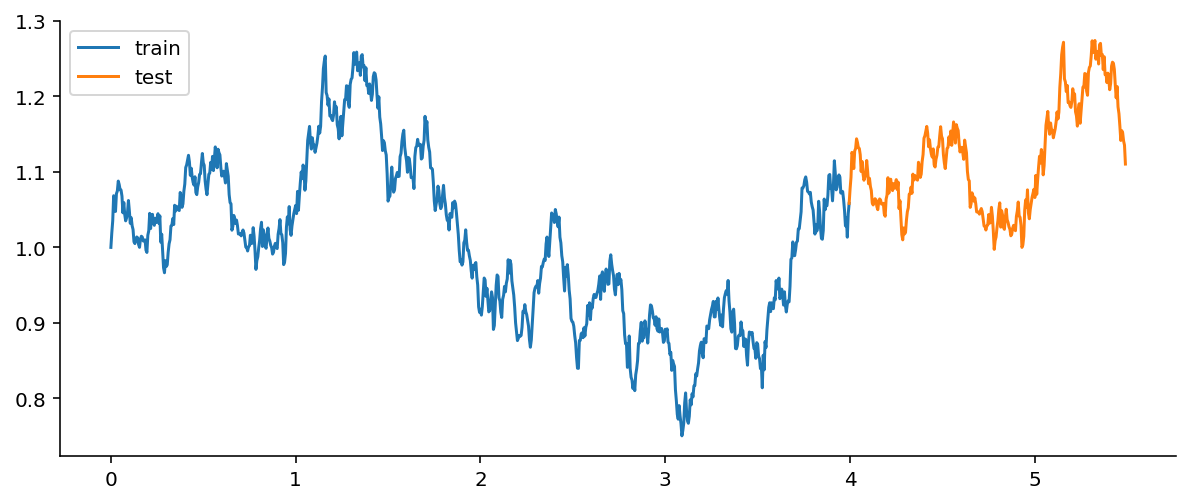

In [96]:
x0 = 1
xbar, kappa, sigma = 1, 1, 0.2
dt = 0.005
seed = 31415
t, x = simulate_ou_process(x0, xbar, kappa, sigma, dt=dt, T=4, seed=seed)
t_test, x_test = simulate_ou_process(x[-1], xbar, kappa, sigma, dt=dt, T=1.5, seed=seed)
t_test = t[-1] + t_test

plt.plot(t, x, label="train")
plt.plot(t_test, x_test, label="test")
plt.legend()

In [162]:
x_train = torch.tensor(x, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

$$
\begin{align}
    z_1 &\sim \mathcal{N}({\bf 0}, {\bf I})\\
    z_t &\sim \mathcal{N}(G_{\alpha}(z_{t-1}, u_{t-1}, \Delta_t), S_{\beta}(z_{t-1}, u_{t-1}, \Delta_t))\\
    x_t &\sim \mathcal{N}(\mu_\theta(z_t), \Sigma_\theta(z_t))
\end{align}
$$

In [99]:
class DKF(nn.Module):
    """
    Deep Kalman Filter
    """
    def __init__(self, nh_ϕ1=10, nh_ϕ2=10, nh_θ1=10, nh_θ2=10):
        super().__init__()
        self.n_in = 1
        # number of hidden variables
        self.n_out = 1
        
        # Network for the latent (posterior) variable
        self.phi_layer1 = nn.Linear(self.n_in, nh_ϕ1)
        self.phi_layer2 = nn.Linear(nh_ϕ1, nh_ϕ2)
        self.mu_phi_network1 = nn.Linear(nh_ϕ2, self.n_out)
        self.logsigma2_phi_network1 = nn.Linear(nh_ϕ2, self.n_out)
        
        # qϕ network: variational model
        input_dim = self.n_out
        self.rnn_mu =  nn.RNN(input_size=input_dim,
                              hidden_size=self.n_out,
                              batch_first=True)
        self.rnn_sigma =  nn.RNN(input_size=input_dim,
                              hidden_size=self.n_out,
                              batch_first=True)
        
        
        # qθ network: generative model
        self.theta_layer1 = nn.Linear(self.n_out, nh_θ1)
        self.theta_layer2 = nn.Linear(nh_θ1, nh_θ2)
        self.mu_theta_network = nn.Linear(nh_θ2, self.n_out)
        self.logsigma2_theta_network = nn.Linear(nh_θ2, self.n_out)
    
    
    def sample_zvar(self, x):
        h1 = F.relu(self.phi_layer1(x))
        h2 = F.relu(self.phi_layer2(h1))
        # Obtaining mean and log-variance of g
        μz = self.mu_phi_network1(h2)
        logσ2z = self.logsigma2_phi_network1(h2)
        # sample n-batches random errors and create
        # an instance of zt
        eps = torch.randn_like(logσ2z)
        σ2z = torch.exp(0.5 * logσ2z)
        zt = μz + σ2z * eps
        return zt
    
    def qϕ_density_params(self, zt):
        rnn_input = zt.view(-1, 1, 1)
        μϕ, _ = self.rnn_mu(rnn_input)
        logσ2ϕ,_ = self.rnn_sigma(rnn_input)
        return μϕ, logσ2ϕ
    
    def norm_samp(self, μ, logσ2):
        eps = torch.randn_like(logσ2)
        σ2 = torch.exp(0.5 * logσ2)
        z = μ + σ2 * eps
        return z
    
    def qθ_density_params(self, z):
        h1 = F.relu(self.theta_layer1(z))
        h2 = F.relu(self.theta_layer2(h1))
        μθ = self.mu_theta_network(h2)
        logσ2 = self.logsigma2_theta_network(h2)
        return μθ, logσ2
        
    def forward(self, x):
        # 1. Sample zt = g(ϕ, xt, ϵ) (variational "E-step")
        zt = self.sample_zvar(x.view(-1, 1))
        # 2. obtain parameters of qϕ
        μϕ, logσ2ϕ = self.qϕ_density_params(zt)
        # sample x
        zt2 = self.norm_samp(μϕ, logσ2ϕ).view(-1, 1)
        μθ, logσ2θ = self.qθ_density_params(zt2)
        return μθ, logσ2θ, μϕ, logσ2ϕ

In [125]:
model = DKF()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [126]:
def loss_function(x, μθ, logσ2θ, μϕ, logσ2ϕ):
    incomplete_expectation = -1/2 * logσ2θ - (x.view(-1, 1) - μθ) ** 2 / (2 * logσ2θ.exp())
    incomplete_expectation = - torch.sum(incomplete_expectation)
    kullback_leibler = -0.5 * torch.sum(1 + logσ2φ - μφ.pow(2) - logσ2φ.exp())
    
    return incomplete_expectation  + kullback_leibler

In [127]:
def train_step(x_train, model):
    model.train()
    optimizer.zero_grad()
    μθ, logσ2θ, μϕ, logσ2ϕ = model(x_train)
    loss = loss_function(x_train, μθ, logσ2θ, μϕ, logσ2ϕ)
    loss.backward()
    train_loss = loss.item()
    optimizer.step()
    return train_loss

In [128]:
train_losses = []
n_epochs = 10_000

for e in range(n_epochs):
    train_loss = train_step(x_train, model)
    train_losses.append(train_loss)

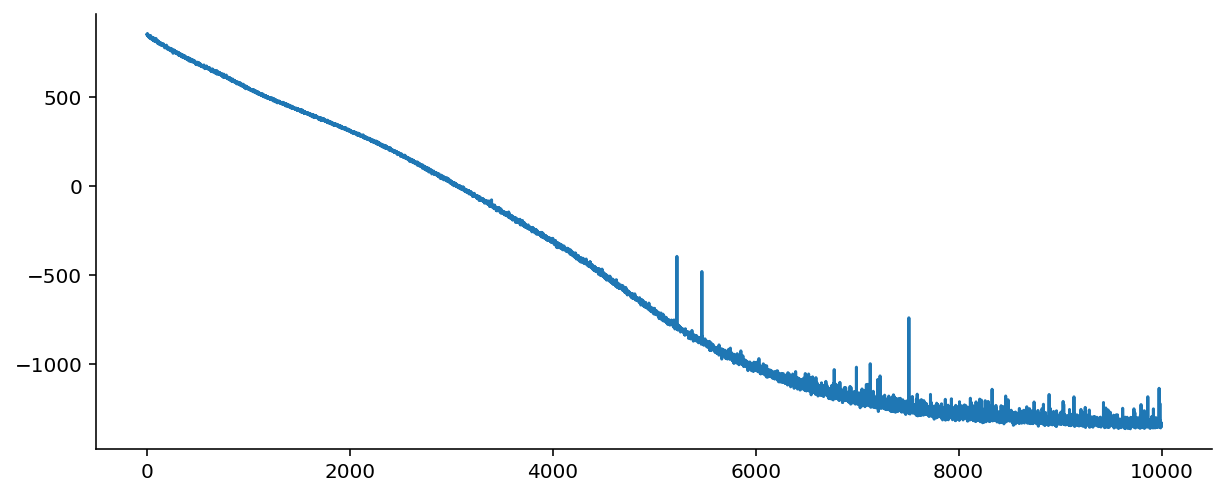

In [129]:
plt.plot(train_losses)

In [181]:
z_test = model.sample_zvar(x_test.view(-1, 1, 1)).view(-1, 1)

In [266]:
x_vals = []
xt = x_train[[0]]

for _ in range(300):
    z_test = model.sample_zvar(xt)
    mu, logsigma2 = model.qϕ_density_params(z_test)
    zt2 = model.norm_samp(mu, logsigma2).view(-1, 1)
    μθ, logσ2θ = model.qθ_density_params(zt2)
    xt = μθ + torch.randn(1) * torch.sqrt(0.5 * logσ2θ.exp())
    x_vals.append(xt)

In [267]:
xt

tensor([[1.0344]], grad_fn=<AddBackward0>)

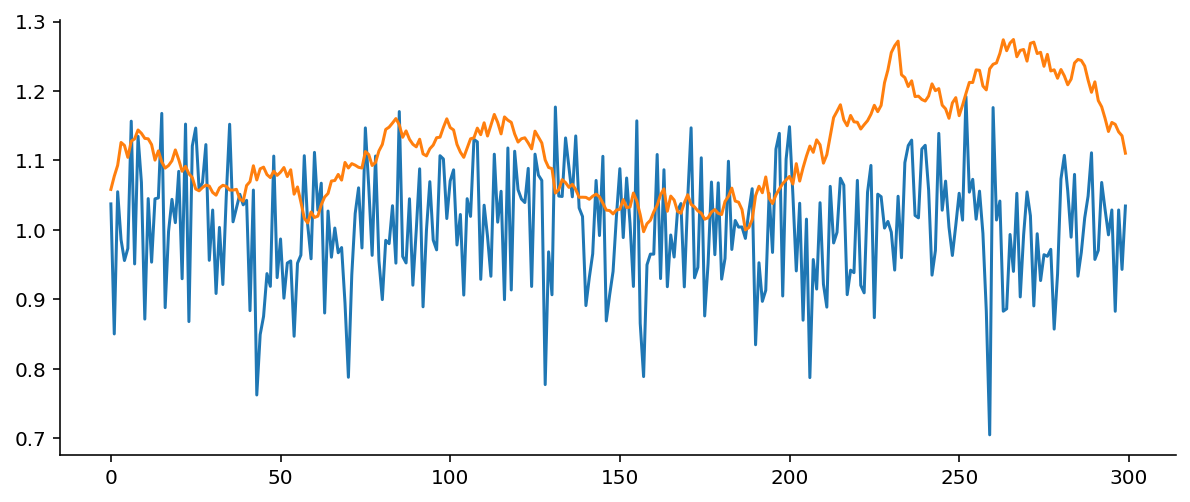

In [268]:
plt.plot(x_vals)
plt.plot(x_test)

### References

* https://github.com/GalaxyFox/DS-GA-3001-Deep_Kalman_Filter/blob/master/q-RNN.ipynb
* https://arxiv.org/pdf/1312.6114.pdf (Appendix B)
* https://arxiv.org/pdf/1906.02691.pdf